### Import dataset

In [17]:
# import dataset with real data
import pandas as pd
import csv

df = pd.read_csv("pfaf_plants_merged.csv")

### Clean dataset

In [19]:
# delete numerical columns, binary columns, and URLs
df = df.drop(columns=["edibility_rating_search", "medicinal_rating_search", "plant_url", "Edibility Rating", "Image URLs", "Medicinal Rating", "Other Uses Rating", "USDA hardiness", "Weed Potential"])

# delete columns with redundant information
df = df.drop(columns=["use_keyword", "Common Name", "Common Names", "Scientific Name", "Summary"])

# delete not useful columns
df = df.drop(columns=["common_name_search", "Care Requirements", "Cultivation Details", "Known Hazards", "Range", "Special Uses"])

### Clean the rich-text  (delete extra spaces and convert to lowercase)
Exclude from lowercase conversion:
- geographical information.

Exclude from the lowercase conversion and the extra spaces deletion:
- scientific nomenclature (scientific name, family).

In [21]:
import re
import spacy

# load a small English model 
nlp = spacy.load("en_core_web_sm")

def clean_text_space_lowercase(text, to_lower=True):
    if pd.isna(text):
        return ""
    text = re.sub(r"\s+", " ", text.strip())  # remove extra spaces
    if to_lower:
        text = text.lower() # convert to lowercase
    return text

df["Edible uses"] = df["Edible Uses"].apply(clean_text_space_lowercase)
df["Medicinal properties"] = df["Medicinal Properties"].apply(clean_text_space_lowercase)
df["Other uses"] = df["Other Uses"].apply(clean_text_space_lowercase)
df["Propagation"] = df["Propagation"].apply(clean_text_space_lowercase)

def clean_text_space(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"\s+", " ", text.strip())  # remove extra spaces
    return text

df["Native area"] = df["Native Range"].apply(clean_text_space)

In [22]:
# delete the columns that are not needed anymore
df = df.drop(columns=["Edible Uses", "Medicinal Properties", "Other Uses", "Native Range"])

In [23]:
# modify name of some columns
df = df.rename(columns={"latin_name_search" : "Scientific name"})

### Chunking the columns with a more structured text

In [26]:
df.head()

,Scientific name,Family,Propagation,Edible uses,Medicinal properties,Other uses,Native area,Propagation_phrases,Edible uses_phrases,Medicinal properties_phrases,Other uses_phrases
0,Abelmoschus moschatus,Malvaceae,seed - sow april in a greenhouse. the seed ger...,edible parts: leaves oil root seed seedpod sho...,antihalitosis; antispasmodic; aphrodisiac; app...,essential fibre insecticide oil size an essent...,"TEMPERATE ASIA: China (Hunan Sheng, Jiangxi Sh...","[seed - sow april in a greenhouse, the seed ge...","[edible parts, leaves oil root seed seedpod sh...","[antihalitosis, antispasmodic, aphrodisiac, ap...",[essential fibre insecticide oil size an essen...
1,Abies grandis,Pinaceae,seed - sow early february in a greenhouse or o...,edible parts: inner bark shoots edible uses: d...,antirheumatic; laxative; ophthalmic; skin; sto...,baby care dye gum incense repellent roofing wo...,"NORTHERN AMERICA: Canada (British Columbia), U...",[seed - sow early february in a greenhouse or ...,"[edible parts, inner bark shoots edible uses, ...","[antirheumatic, laxative, ophthalmic, skin, st...",[baby care dye gum incense repellent roofing w...
2,Abies spectabilis,Pinaceae,seed - sow early february in a greenhouse or o...,none known,antiperiodic; astringent; carminative; expecto...,essential fuel incense wood an essential oil i...,"TEMPERATE ASIA: Afghanistan, China (Xizang Ziz...",[seed - sow early february in a greenhouse or ...,[none known],"[antiperiodic, astringent, carminative, expect...",[essential fuel incense wood an essential oil ...
3,Abutilon theophrasti,Malvaceae,seed - sow early april in a greenhouse. germin...,edible parts: fruit oil seed edible uses: oil ...,astringent; demulcent; diuretic; dysentery; em...,fibre oil paper a fibre obtained from the stem...,"TEMPERATE ASIA: Afghanistan, Egypt (Sinai), Ir...","[seed - sow early april in a greenhouse, germi...","[edible parts, fruit oil seed edible uses, oil...","[astringent, demulcent, diuretic, dysentery, e...",[fibre oil paper a fibre obtained from the ste...
4,Acacia farnesiana,Fabaceae or Leguminosae,seed - best sown as soon as it is ripe in a su...,edible parts: edible uses: gum gum a low-quali...,astringent; demulcent; dysentery; poultice; st...,adhesive dye essential gum gum ink tannin teet...,NORTHERN AMERICA: United States (Florida (nort...,[seed - best sown as soon as it is ripe in a s...,"[edible parts, edible uses, gum gum a low-qual...","[astringent, demulcent, dysentery, poultice, s...",[adhesive dye essential gum gum ink tannin tee...


In [25]:
def extract_phrases(text):
    if pd.isna(text):
        return []
    phrases = re.split(r"[;,:.]", text)
    return [phrase.strip().lower() for phrase in phrases if phrase.strip()]

df["Propagation_phrases"] = df["Propagation"].apply(extract_phrases)
df["Edible uses_phrases"] = df["Edible uses"].apply(extract_phrases)
df["Medicinal properties_phrases"] = df["Medicinal properties"].apply(extract_phrases)
df["Other uses_phrases"] = df["Other uses"].apply(extract_phrases)

### Propagation - Germination time vs sowing month (plant's numbers)
- prepare the column for further visualization

In [27]:
# split the text into phrases based on periods followed by space or end of line
def split_phrases(text):
    if pd.isna(text):
        return []
    return [phrase.strip().lower() for phrase in re.split(r"[.]\s*", text) if phrase.strip()]

# define keyword-based categorization
def categorize_phrase(phrase):
    if not isinstance(phrase, str):
        return "unknown"
    
    phrase = phrase.lower()
    if any(kw in phrase for kw in ["sow", "sown", "sowing"]):
        return "sowing"
    elif any(kw in phrase for kw in ["stratification", "scarify", "pre-soak"]):
        return "seed preparation"
    elif any(kw in phrase for kw in ["germinate", "germination"]):
        return "germination"
    elif any(kw in phrase for kw in ["prick", "pots", "seedlings"]):
        return "first potting"
    elif "division" in phrase:
        return "division"
    elif any(kw in phrase for kw in ["plant out", "permanent position", "planted"]):
        return "first planting"
    elif any(kw in phrase for kw in ["cutting", "basal", "half-ripe"]):
        return "cutting"
    elif any(kw in phrase for kw in ["collect", "pot", "shoots"]):
        return "second potting"        
    elif any(kw in phrase for kw in ["root", "ready", "plant"]):
        return "second planting"
    else:
        return "other"

# apply the function to the Propagation column
# split and categorize
df["propagation_steps"] = df["Propagation"].apply(split_phrases)

# expand and categorize
df_exploded = df.explode("propagation_steps").copy()
df_exploded["propagation_phase"] = df_exploded["propagation_steps"].apply(categorize_phrase)

# group by family and propagation phase
df_family = (df_exploded.groupby(["Family", "propagation_phase", "propagation_steps"]).size().reset_index(name="count"))

The df_exploded with the code above and the division of df["Propagation"] into df["propagation_steps"] and df["propagation_phase"] could be used into a model.

In [28]:
# extract the number of weeks/months from the propagation phase sowing
import re
import numpy as np

def extract_germination_time(text):
    if pd.isna(text):
        return np.nan

    # Normalize text
    text = text.lower()

    # Match expressions like "germinate... X weeks" or "germination... X - Y weeks"
    pattern = r"(?:germinates|germination(?: takes| is)?)(?:.*?)(\d+)(?:\s*[-to]{1,3}\s*(\d+))?\s*(weeks?|months?)"

    match = re.search(pattern, text)
    if match:
        start = int(match.group(1))
        end = match.group(2)
        unit = match.group(3)

        if end:
            end = int(end)
            avg = (start + end) / 2
        else:
            avg = start

        if "month" in unit:
            avg *= 4  # convert months to weeks

        return avg  # return average germination time in weeks

    return np.nan

# apply the function to the Propagation column
df["germination_weeks"] = df["Propagation"].apply(extract_germination_time)

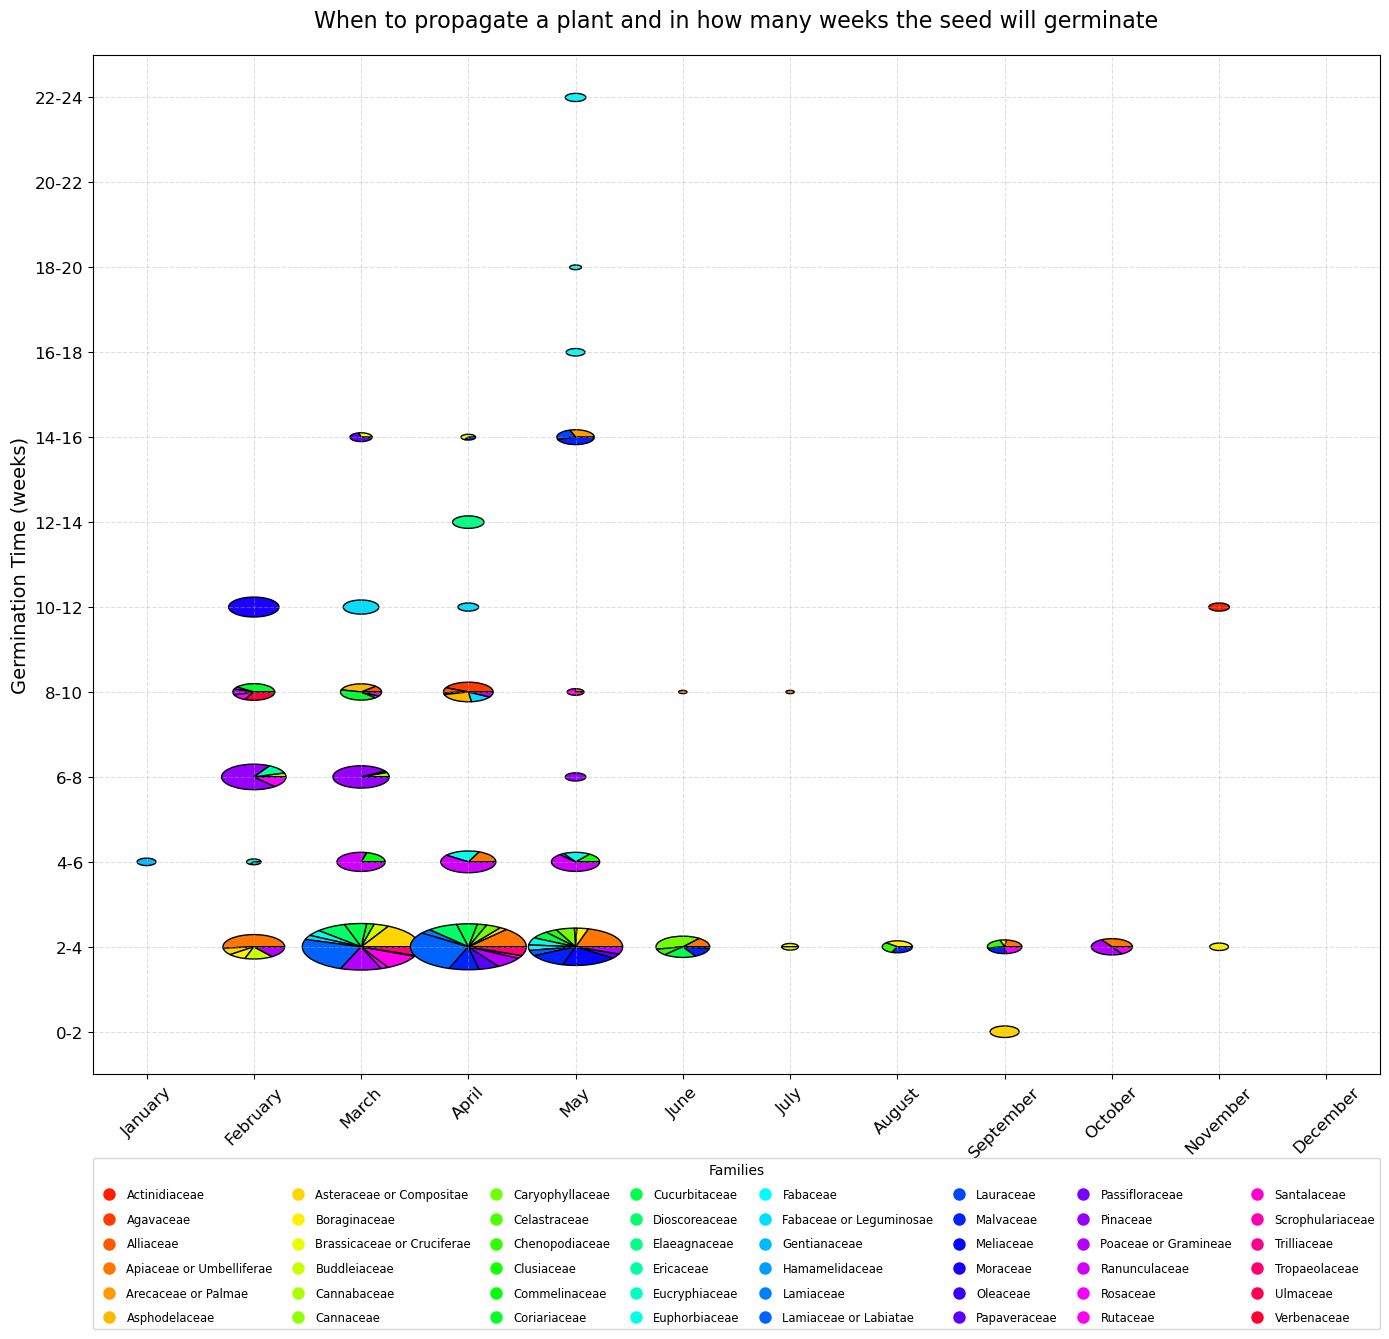

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# --- Function to extract months from a text ---
def extract_months(text):
    if pd.isna(text):
        return []
    months = [
        "january", "february", "march", "april", "may", "june",
        "july", "august", "september", "october", "november", "december"
    ]
    found = []
    for m in months:
        if re.search(rf"\b{m}\b", str(text).lower()):
            found.append(m.capitalize())
    return found

# --- Function to detect sowing-related propagation steps ---
def is_sowing_step(text):
    if pd.isna(text):
        return False
    return bool(re.search(r"\bsow|seeding|plant\b", text.lower()))

# Split propagation column into steps (lowercase and stripped)
df["propagation_steps"] = df["Propagation"].apply(
    lambda text: [] if pd.isna(text) else [p.strip().lower() for p in re.split(r"[.]\s*", text) if p.strip()]
)

# Keep only sowing-related steps
df["sowing_steps"] = df["propagation_steps"].apply(
    lambda steps: [s for s in steps if is_sowing_step(s)]
)

# Explode sowing steps for month extraction
df_exploded = df.explode("sowing_steps").copy()

# Extract months only from sowing steps
df_exploded["sowing_months"] = df_exploded["sowing_steps"].apply(extract_months)

# Explode months and drop missing months or germination weeks
df_months = df_exploded.explode("sowing_months").dropna(subset=["sowing_months"])
df_months = df_months.dropna(subset=["germination_weeks"])
df_months_filtered = df_months.copy()

# Map month names to numeric x values
month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]
month_to_num = {m: i for i, m in enumerate(month_order)}

df_months_filtered.loc[:, "month_num"] = df_months_filtered["sowing_months"].map(month_to_num)

# Define germination time bins (y-axis)
bins = list(range(0, 26, 2))  # [0, 2, 4, ..., 24]
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
df_months_filtered.loc[:, "germ_bin"] = pd.cut(df_months_filtered["germination_weeks"], bins=bins, labels=labels, right=False)

# Group by month_num, germ_bin, Family to get counts
grouped = df_months_filtered.groupby(["month_num", "germ_bin", "Family"], observed=True).size().reset_index(name='count')

# Pivot to get families as columns
pivot = grouped.pivot_table(index=["month_num", "germ_bin"], columns="Family", values="count", fill_value=0, observed=True)

# Calculate total count per bin for circle size
pivot["total"] = pivot.sum(axis=1)

# Remove zero totals
pivot = pivot[pivot["total"] > 0]

# Prepare plot
fig, ax = plt.subplots(figsize=(14, 15))

# Normalize circle sizes
max_size = 3000  # max circle area
pivot["size"] = (pivot["total"] / pivot["total"].max()) * max_size

# Calculate germination bin centers for y-axis
germ_bin_centers = {label: (bins[i] + bins[i+1]) / 2 for i, label in enumerate(labels)}

# Colors for families
unique_families = sorted(df_months_filtered["Family"].unique())
palette = sns.color_palette("hsv", len(unique_families))
family_colors = {fam: palette[i] for i, fam in enumerate(unique_families)}

# Function to draw pie charts at given positions
def draw_pie(ax, xpos, ypos, sizes, colors, size):
    start = 0
    for frac, color in zip(sizes, colors):
        if frac == 0:
            continue
        theta1 = start * 360
        theta2 = (start + frac) * 360
        wedge = plt.matplotlib.patches.Wedge(center=(xpos, ypos), r=size,
                                            theta1=theta1, theta2=theta2,
                                            facecolor=color, edgecolor='k')
        ax.add_patch(wedge)
        start += frac

# Plot pie charts for each month_num and germ_bin
for (month_num, germ_bin), row in pivot.iterrows():
    ypos = germ_bin_centers[germ_bin]
    xpos = month_num
    size = np.sqrt(row["size"]) / 100  # adjust scale as needed

    family_counts = row.drop(["total", "size"])
    total = family_counts.sum()
    fracs = family_counts / total if total > 0 else family_counts

    draw_pie(ax, xpos, ypos, fracs, [family_colors[fam] for fam in family_counts.index], size)

# Format axes and labels
ax.set_xticks(range(len(month_order)))
ax.set_xticklabels(month_order, rotation=45, fontsize=12)
ax.set_ylabel("Germination Time (weeks)", fontsize=14)
ax.set_yticks(list(germ_bin_centers.values()))
ax.set_yticklabels(labels, fontsize=12)
ax.set_xlim(-0.5, 11.5)
ax.set_ylim(min(bins), max(bins))
ax.grid(True, linestyle='--', alpha=0.4)

# Legend for families below plot
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=fam,
               markerfacecolor=family_colors[fam], markersize=10)
    for fam in unique_families
]

ax.legend(handles=handles, title="Families",
          loc='lower center',
          bbox_to_anchor=(0, -0.25, 1, 0.3),
          mode='expand', borderaxespad=0,
          ncol=8,
          fontsize='small',
          handletextpad=0.5,
          labelspacing=1.0)

plt.subplots_adjust(bottom=0.4)  # bottom margin for legend
plt.title("When to propagate a plant and in how many weeks the seed will germinate", fontsize=16, pad=20)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

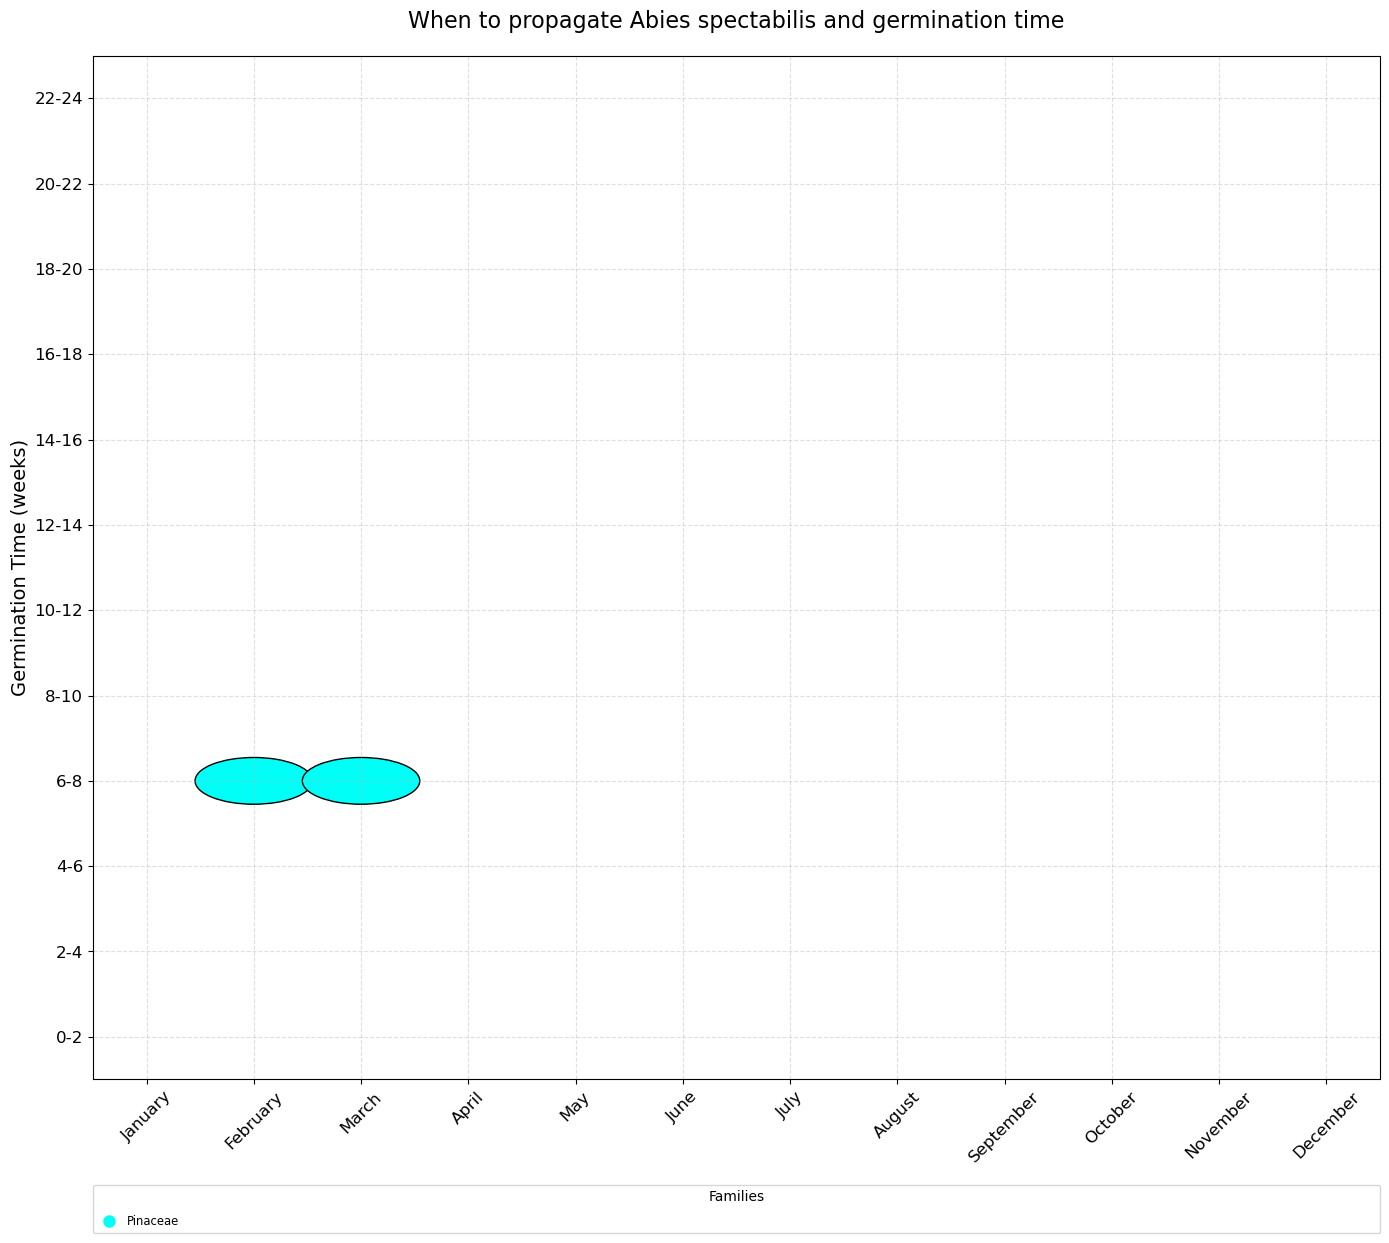

In [30]:
# --- Function to extract months from a text ---
def extract_months(text):
    if pd.isna(text):
        return []
    months = [
        "january", "february", "march", "april", "may", "june",
        "july", "august", "september", "october", "november", "december"
    ]
    found = []
    for m in months:
        if re.search(rf"\b{m}\b", str(text).lower()):
            found.append(m.capitalize())
    return found

# --- Function to detect sowing-related propagation steps ---
def is_sowing_step(text):
    if pd.isna(text):
        return False
    return bool(re.search(r"\bsow|seeding|plant\b", text.lower()))

def plot_plant_germination(df, plant_name):
    # Filter for the plant
    df_plant = df[df["Scientific name"].str.lower() == plant_name.lower()].copy()
    
    if df_plant.empty:
        print(f"No data found for plant: {plant_name}")
        return
    
    # Split propagation column into steps (lowercase and stripped)
    df_plant["propagation_steps"] = df_plant["Propagation"].apply(
        lambda text: [] if pd.isna(text) else [p.strip().lower() for p in re.split(r"[.]\s*", text) if p.strip()]
    )
    
    # Keep only sowing-related steps
    df_plant["sowing_steps"] = df_plant["propagation_steps"].apply(
        lambda steps: [s for s in steps if is_sowing_step(s)]
    )
    
    # Explode sowing steps for month extraction
    df_exploded = df_plant.explode("sowing_steps").copy()
    
    # Extract months only from sowing steps
    df_exploded["sowing_months"] = df_exploded["sowing_steps"].apply(extract_months)
    
    # Explode months and drop missing months or germination weeks
    df_months = df_exploded.explode("sowing_months").dropna(subset=["sowing_months"])
    df_months = df_months.dropna(subset=["germination_weeks"])
    df_months_filtered = df_months.copy()
    
    # Map month names to numeric x values
    month_order = [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]
    month_to_num = {m: i for i, m in enumerate(month_order)}
    
    df_months_filtered.loc[:, "month_num"] = df_months_filtered["sowing_months"].map(month_to_num)
    
    # Define germination time bins (y-axis)
    bins = list(range(0, 26, 2))  # [0, 2, 4, ..., 24]
    labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
    df_months_filtered.loc[:, "germ_bin"] = pd.cut(df_months_filtered["germination_weeks"], bins=bins, labels=labels, right=False)
    
    # Group by month_num, germ_bin, Family to get counts
    grouped = df_months_filtered.groupby(["month_num", "germ_bin", "Family"], observed=True).size().reset_index(name='count')
    
    # Pivot to get families as columns
    pivot = grouped.pivot_table(index=["month_num", "germ_bin"], columns="Family", values="count", fill_value=0, observed=True)
    
    # Calculate total count per bin for circle size
    pivot["total"] = pivot.sum(axis=1)
    
    # Remove zero totals
    pivot = pivot[pivot["total"] > 0]
    
    if pivot.empty:
        print(f"No sowing and germination data available to plot for {plant_name}.")
        return
    
    # Prepare plot
    fig, ax = plt.subplots(figsize=(14, 15))
    
    # Normalize circle sizes
    max_size = 3000  # max circle area
    pivot["size"] = (pivot["total"] / pivot["total"].max()) * max_size
    
    # Calculate germination bin centers for y-axis
    germ_bin_centers = {label: (bins[i] + bins[i+1]) / 2 for i, label in enumerate(labels)}
    
    # Colors for families
    unique_families = sorted(df_months_filtered["Family"].unique())
    palette = sns.color_palette("hsv", len(unique_families))
    family_colors = {fam: palette[i] for i, fam in enumerate(unique_families)}
    
    # Function to draw pie charts at given positions
    def draw_pie(ax, xpos, ypos, sizes, colors, size):
        start = 0
        for frac, color in zip(sizes, colors):
            if frac == 0:
                continue
            theta1 = start * 360
            theta2 = (start + frac) * 360
            wedge = plt.matplotlib.patches.Wedge(center=(xpos, ypos), r=size,
                                                theta1=theta1, theta2=theta2,
                                                facecolor=color, edgecolor='k')
            ax.add_patch(wedge)
            start += frac
    
    # Plot pie charts for each month_num and germ_bin
    for (month_num, germ_bin), row in pivot.iterrows():
        ypos = germ_bin_centers[germ_bin]
        xpos = month_num
        size = np.sqrt(row["size"]) / 100  # adjust scale as needed
    
        family_counts = row.drop(["total", "size"])
        total = family_counts.sum()
        fracs = family_counts / total if total > 0 else family_counts
    
        draw_pie(ax, xpos, ypos, fracs, [family_colors[fam] for fam in family_counts.index], size)
    
    # Format axes and labels
    ax.set_xticks(range(len(month_order)))
    ax.set_xticklabels(month_order, rotation=45, fontsize=12)
    ax.set_ylabel("Germination Time (weeks)", fontsize=14)
    ax.set_yticks(list(germ_bin_centers.values()))
    ax.set_yticklabels(labels, fontsize=12)
    ax.set_xlim(-0.5, 11.5)
    ax.set_ylim(min(bins), max(bins))
    ax.grid(True, linestyle='--', alpha=0.4)
    
    # Legend for families below plot
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label=fam,
                   markerfacecolor=family_colors[fam], markersize=10)
        for fam in unique_families
    ]
    
    ax.legend(handles=handles, title="Families",
              loc='lower center',
              bbox_to_anchor=(0, -0.15, 1, 0.3),
              mode='expand', borderaxespad=0,
              ncol=8,
              fontsize='small',
              handletextpad=0.5,
              labelspacing=1.0)
    
    plt.subplots_adjust(bottom=0.1)  # bottom margin for legend
    plt.title(f"When to propagate {plant_name} and germination time", fontsize=16, pad=20)
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.show()

# Usage example:
plot_plant_germination(df, "Abies spectabilis")

### Native area - Diffusion area

Use chunking, not just tokenization, before NER:

1. Split by commas → gives you candidate chunks
2. Strip parentheses content when needed
3. Apply NER on chunks
4. Fallback to pycountry check

In [ ]:
import spacy
import pycountry
import pandas as pd
import re
import time

# Load spaCy and disable unnecessary components for speed
nlp = spacy.load("en_core_web_sm")
nlp.disable_pipes("tagger", "parser")

# ISO country names only (no subdivisions)
all_country_names = sorted({c.name for c in pycountry.countries})
country_names_lower = {name.lower(): name for name in all_country_names}

# Precompile regex for country names
country_patterns = [(name, re.compile(r'\b' + re.escape(name) + r'\b', re.IGNORECASE))
                    for name in all_country_names]

# Manual aliases
manual_aliases = {
    "Taiwan": "Taiwan",
    "Vietnam": "Viet Nam",
    "Laos": "Lao People's Democratic Republic",
    "People's Republic of China": "China",
    "PRC": "China",
    "Korea South": "Korea, Republic of",
    "South Korea": "Korea, Republic of",
    "Korea North": "Korea, Democratic People's Republic of",
    "North Korea": "Korea, Democratic People's Republic of",
    "Iran": "Iran, Islamic Republic of",
    "Turkey": "Türkiye",
    "Moldova": "Moldova, Republic of",
    "Yugoslavia": "Yugoslavia",
    "Czech Republic": "Czechia"
}

# GPEs to exclude (non-countries)
excluded_gpes = {"Indochina", "Northern Territory", "Himalayas", "Siberia", "Greenland"}

def clean_text(text):
    if not isinstance(text, str):
        return ""

    # Insert comma before uppercase region labels if missing
    # This handles cases like 'Turkey TROPICAL ASIA' → 'Turkey, TROPICAL ASIA'
    text = re.sub(r'(?<![,])(\s+)([A-Z]{2,}(?:\s[A-Z]{2,})*)\b', r', \2', text)

    # Remove parentheses and their content
    text = re.sub(r"\(.*?\)", "", text)

    # Remove punctuation except commas
    text = re.sub(r"[^\w\s,]", "", text)

    # Collapse multiple spaces and commas into a single comma
    text = re.sub(r"\s+", " ", text)           # collapse spaces
    text = re.sub(r",\s*,", ",", text)        # remove duplicate commas
    text = re.sub(r"\s*,\s*", ",", text)      # remove spaces around commas

    # Remove leading/trailing commas and spaces
    text = text.strip(" ,")

    return text

def normalize_aliases(name):
    key = name.replace(",", "").replace(" ", "").lower()
    for alias, official in manual_aliases.items():
        alias_key = alias.replace(" ", "").lower()
        if key == alias_key:
            return official
    return name

texts = df["Native area"].fillna("").astype(str).tolist()

results = []
start = time.time()

for i, text in enumerate(texts):
    cleaned = clean_text(text)
    matched = set()

    # Flags for presence in original/cleaned text
    has_china = bool(re.search(r'\bChina\b', cleaned, re.IGNORECASE) or
                     re.search(r'\bPeople\'s Republic of China\b', cleaned, re.IGNORECASE) or
                     re.search(r'\bPRC\b', cleaned, re.IGNORECASE))
    has_taiwan = bool(re.search(r'\bTaiwan\b', cleaned, re.IGNORECASE))
    has_south_korea = bool(re.search(r'\bSouth Korea\b', cleaned, re.IGNORECASE) or
                           re.search(r'\bKorea South\b', cleaned, re.IGNORECASE))
    has_north_korea = bool(re.search(r'\bNorth Korea\b', cleaned, re.IGNORECASE) or
                           re.search(r'\bKorea North\b', cleaned, re.IGNORECASE))

    # 1. Regex match known countries
    for name, pattern in country_patterns:
        if pattern.search(cleaned):
            matched.add(name)

    # 2. Manual alias mapping for any alias found in cleaned text
    for alias, official in manual_aliases.items():
        if re.search(r'\b' + re.escape(alias) + r'\b', cleaned, re.IGNORECASE):
            matched.add(official)

    # 3. Explicitly add countries if present
    if has_china:
        matched.add("China")
    if has_taiwan:
        matched.add("Taiwan")
    if has_south_korea:
        matched.add("South Korea")
    if has_north_korea:
        matched.add("North Korea")

    # 4. NER fallback with blacklist filtering
    doc = nlp(cleaned)
    for ent in doc.ents:
        if ent.label_ == "GPE":
            ent_text = ent.text.strip()
            if ent_text not in excluded_gpes:
                ent_text_lower = ent_text.lower()
                if ent_text_lower in country_names_lower:
                    matched.add(country_names_lower[ent_text_lower])

    # 5. Remove substrings if longer names present (e.g., keep Papua New Guinea, drop Papua)
    final_matches = set()
    for name in matched:
        if not any(name != other and name in other for other in matched):
            final_matches.add(name)

    results.append(sorted(final_matches))

df["native_countries"] = results

print(f"NER country extraction completed in {time.time() - start:.2f} seconds")

c:\Users\DELL\anaconda3\envs\neuralnet\lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


NER country extraction completed in 255.18 seconds


In [ ]:
# df.to_excel("plants_native_countries.xlsx", index=False)

In [178]:
print(sorted(world['ADMIN'].unique()))

['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antarctica', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Falkland Islands', 'Fiji', 'Finland', 'France', 'French Southern and Antarctic Lands', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Greenland', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Ivory Coast', 'Jamaica', 'Japan', 'Jordan

In [ ]:
import geopandas as gpd
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import numpy as np

manual_aliases = {
    "Taiwan": "Taiwan",
    "Vietnam": "Vietnam",
    "Laos": "Laos",
    "People's Republic of China": "China",
    "PRC": "China",
    "Korea South": "South Korea",
    "South Korea": "South Korea",
    "Korea North": "North Korea",
    "North Korea": "North Korea",
    "Iran": "Iran",
    "Turkey": "Turkey",
    "Moldova": "Moldova",
    "Yugoslavia": "Republic of Serbia",   # since Yugoslavia no longer exists, map it to a current name; or skip if you want exact
    "Czech Republic": "Czechia",
    "Russia": "Russia",
    "United States of America": "United States of America",
    "United States": "United States of America",  # just in case
}

# --------------------
# 1. Explode into long format: one row per (Family, country)
# --------------------
native = df[["Family", "native_countries"]].explode("native_countries").rename(columns={"native_countries": "country"})

# 2. Replace aliases on the exploded dataframe
native["country"] = native["country"].replace(manual_aliases)

# --------------------
# 2. Load world shapefile (Cartopy downloads once)
# --------------------
shpfilename = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
world = gpd.read_file(shpfilename)

# --------------------
# 3. Merge extracted data into a copy of the map (non-destructive to df)
# --------------------
world_native = world.copy()

# Add empty Family column (to be filled via merge)
world_native["Family"] = np.nan

# Merge Family info into the map using country name
world_native = world_native.merge(
    native.drop_duplicates(subset=["Family", "country"]),
    left_on="ADMIN",
    right_on="country",
    how="left"
)

# Clean up columns after merge
world_native["Family"] = world_native["Family_y"]
world_native.drop(columns=["country", "Family_x", "Family_y"], inplace=True)

# --------------------
# 4. Plot Native area map
# --------------------
fig, ax = plt.subplots(figsize=(18, 14))

world_native.plot(
    column="Family",
    ax=ax,
    cmap="tab20",
    legend=True,
    edgecolor="black",
    legend_kwds={
        "loc": "upper left",
        "bbox_to_anchor": (0.5, -0.1),
        "title": "Family"
    },
    missing_kwds={
        "color": "lightgray",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data",
    }
)

ax.set_title("Plant Families Distribution")
ax.axis("off")

plt.show()

In [35]:
df.head()

,Scientific name,Family,Propagation,Edible uses,Medicinal properties,Other uses,Native area,Propagation_phrases,Edible uses_phrases,Medicinal properties_phrases,Other uses_phrases,propagation_steps,germination_weeks,sowing_steps
0,Abelmoschus moschatus,Malvaceae,seed - sow april in a greenhouse. the seed ger...,edible parts: leaves oil root seed seedpod sho...,antihalitosis; antispasmodic; aphrodisiac; app...,essential fibre insecticide oil size an essent...,"TEMPERATE ASIA: China (Hunan Sheng, Jiangxi Sh...","[seed - sow april in a greenhouse, the seed ge...","[edible parts, leaves oil root seed seedpod sh...","[antihalitosis, antispasmodic, aphrodisiac, ap...",[essential fibre insecticide oil size an essen...,"[seed - sow april in a greenhouse, the seed ge...",NaN,"[seed - sow april in a greenhouse, when large ..."
1,Abies grandis,Pinaceae,seed - sow early february in a greenhouse or o...,edible parts: inner bark shoots edible uses: d...,antirheumatic; laxative; ophthalmic; skin; sto...,baby care dye gum incense repellent roofing wo...,"NORTHERN AMERICA: Canada (British Columbia), U...",[seed - sow early february in a greenhouse or ...,"[edible parts, inner bark shoots edible uses, ...","[antirheumatic, laxative, ophthalmic, skin, st...",[baby care dye gum incense repellent roofing w...,[seed - sow early february in a greenhouse or ...,7.0,[seed - sow early february in a greenhouse or ...
2,Abies spectabilis,Pinaceae,seed - sow early february in a greenhouse or o...,none known,antiperiodic; astringent; carminative; expecto...,essential fuel incense wood an essential oil i...,"TEMPERATE ASIA: Afghanistan, China (Xizang Ziz...",[seed - sow early february in a greenhouse or ...,[none known],"[antiperiodic, astringent, carminative, expect...",[essential fuel incense wood an essential oil ...,[seed - sow early february in a greenhouse or ...,7.0,[seed - sow early february in a greenhouse or ...
3,Abutilon theophrasti,Malvaceae,seed - sow early april in a greenhouse. germin...,edible parts: fruit oil seed edible uses: oil ...,astringent; demulcent; diuretic; dysentery; em...,fibre oil paper a fibre obtained from the stem...,"TEMPERATE ASIA: Afghanistan, Egypt (Sinai), Ir...","[seed - sow early april in a greenhouse, germi...","[edible parts, fruit oil seed edible uses, oil...","[astringent, demulcent, diuretic, dysentery, e...",[fibre oil paper a fibre obtained from the ste...,"[seed - sow early april in a greenhouse, germi...",2.5,"[seed - sow early april in a greenhouse, when ..."
4,Acacia farnesiana,Fabaceae or Leguminosae,seed - best sown as soon as it is ripe in a su...,edible parts: edible uses: gum gum a low-quali...,astringent; demulcent; dysentery; poultice; st...,adhesive dye essential gum gum ink tannin teet...,NORTHERN AMERICA: United States (Florida (nort...,[seed - best sown as soon as it is ripe in a s...,"[edible parts, edible uses, gum gum a low-qual...","[astringent, demulcent, dysentery, poultice, s...",[adhesive dye essential gum gum ink tannin tee...,[seed - best sown as soon as it is ripe in a s...,3.5,[seed - best sown as soon as it is ripe in a s...


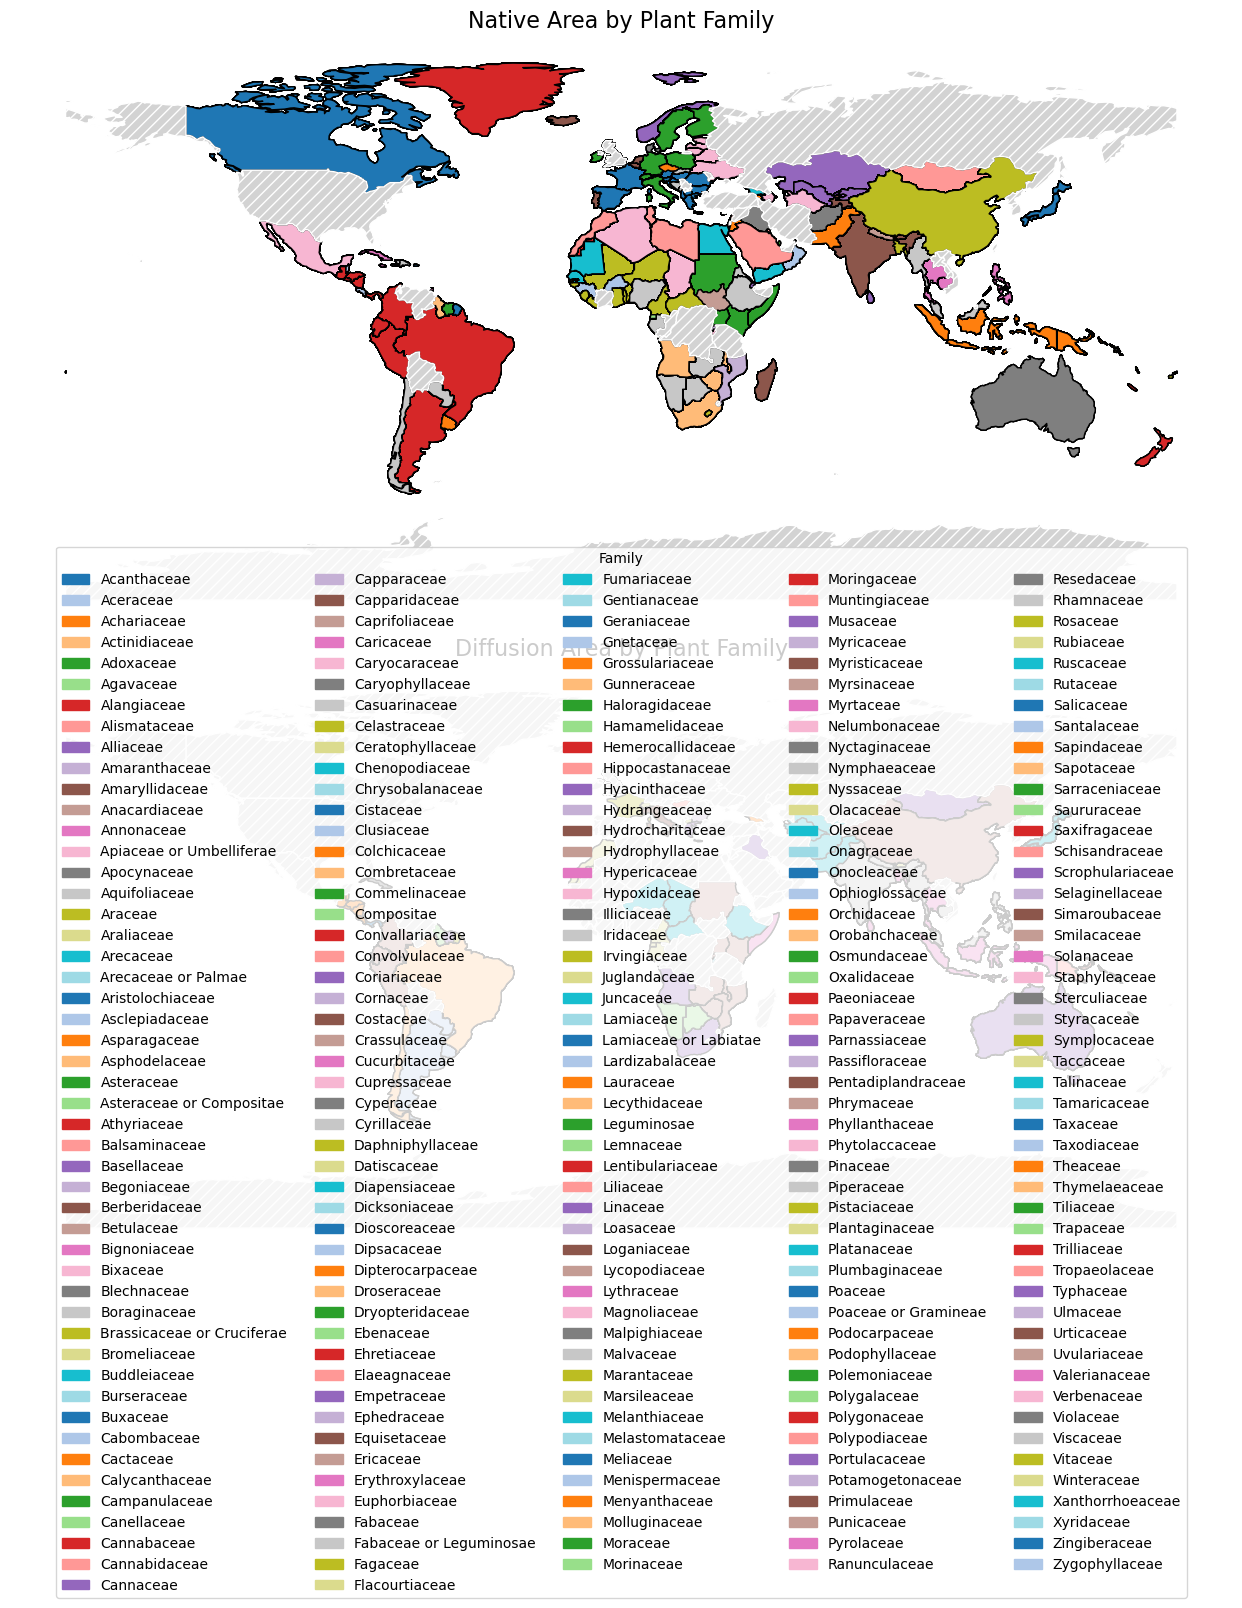

In [14]:
import pycountry
import re
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.io.shapereader as shpreader

# Load known countries and subdivisions
known_countries = {c.name for c in pycountry.countries}
known_subdivisions = {s.name for s in pycountry.subdivisions}

# ----------- FAST GEOGRAPHICAL EXTRACTION (no spaCy) ----------- #
def extract_geographical_scope_fast(text):
    if not isinstance(text, str):
        return []

    found = set()
    chunks = [re.sub(r"\(.*?\)", "", c).strip() for c in text.split(",")]

    for chunk in chunks:
        if chunk in known_countries or chunk in known_subdivisions:
            found.add(chunk)
        else:
            # Try loose match
            for country in known_countries:
                if chunk.lower() in country.lower():
                    found.add(country)
                    break

    return sorted(found)

# ----------- YOUR FULL DF IS ALREADY LOADED BEFORE THIS POINT ----------- #
# We only add new columns; df is not overwritten

# Extract countries
df["native_countries"] = df["Native area"].apply(extract_geographical_scope_fast)
df["diffusion_countries"] = df["Diffusion area"].apply(extract_geographical_scope_fast)

# Explode to long format
native = df[["Family", "native_countries"]].explode("native_countries").rename(columns={"native_countries": "country"})
diffusion = df[["Family", "diffusion_countries"]].explode("diffusion_countries").rename(columns={"diffusion_countries": "country"})

# Load Natural Earth countries
shpfilename = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
world = gpd.read_file(shpfilename)

# Prepare for native and diffusion overlays
world_native = world.copy()
world_diffusion = world.copy()
world_native["Family"] = np.nan
world_diffusion["Family"] = np.nan

# Merge family info for native area
world_native = world_native.merge(native.drop_duplicates(subset=["Family", "country"]),
                                  left_on="ADMIN", right_on="country", how="left")
world_native["Family"] = world_native["Family_y"]
world_native.drop(columns=["country", "Family_x", "Family_y"], inplace=True)

# Merge family info for diffusion area
world_diffusion = world_diffusion.merge(diffusion.drop_duplicates(subset=["Family", "country"]),
                                        left_on="ADMIN", right_on="country", how="left")
world_diffusion["Family"] = world_diffusion["Family_y"]
world_diffusion.drop(columns=["country", "Family_x", "Family_y"], inplace=True)

# ----------- PLOTTING ----------- #
import matplotlib.patches as mpatches

fig, axes = plt.subplots(2, 1, figsize=(18, 14))

# Use a consistent colormap across both plots
cmap = plt.get_cmap("tab20")

# Get all unique families from both maps
all_families = pd.concat([world_native["Family"].dropna(),
                          world_diffusion["Family"].dropna()]).unique()
all_families = sorted(all_families)

# Create a mapping: Family → Color
color_mapping = {fam: cmap(i % 20) for i, fam in enumerate(all_families)}

# Plot Native
world_native.plot(column="Family",
                  ax=axes[0],
                  cmap=cmap,
                  legend=False,
                  edgecolor="black",
                  missing_kwds={
                      "color": "lightgray",
                      "edgecolor": "white",
                      "hatch": "///",
                      "label": "No data"
                  })
axes[0].set_title("Native Area by Plant Family", fontsize=16)
axes[0].axis("off")

# Plot Diffusion
world_diffusion.plot(column="Family",
                     ax=axes[1],
                     cmap=cmap,
                     legend=False,
                     edgecolor="black",
                     missing_kwds={
                         "color": "lightgray",
                         "edgecolor": "white",
                         "hatch": "///",
                         "label": "No data"
                     })
axes[1].set_title("Diffusion Area by Plant Family", fontsize=16)
axes[1].axis("off")

# Custom legend below
patches = [mpatches.Patch(color=color_mapping[fam], label=fam) for fam in all_families]

# Add legend below the plots
fig.legend(handles=patches,
           loc="lower center",
           bbox_to_anchor=(0.5, -0.15),
           ncol=5,  # Adjust based on how many families
           fontsize=10,
           title="Family")

plt.tight_layout()
plt.subplots_adjust(bottom=0.10)  # Make room for the legend
plt.show()

### Medicinal property vs Edibility

In [15]:
import pandas as pd
import spacy
import re

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# --- Define known plant parts and useful edible use keywords ---
plant_part_keywords = {
    "bark", "leaf", "leaves", "root", "seed", "shoot", "gum", "pod",
    "tip", "fruit", "oil", "trunk", "sap", "resin", "flower", "stem"
}

known_uses_keywords = {
    "tea", "drink", "chewing gum", "paste", "chutney", "seasoning", "thickener",
    "bread", "food", "sauce", "cooked", "dried", "juice", "fermented", "alcohol",
    "flour", "gum", "spice", "masticatory", "substitute", "sweetener", "emergency food"
}

# --- Clean brackets and references robustly ---
def clean_text_list(text_list):
    cleaned = []
    for phrase in text_list:
        # Remove bracketed numbers like [123]
        phrase = re.sub(r'\[\d+\]', '', phrase)
        # Remove fragments like gum[226, food[105, etc.
        phrase = re.sub(r'\b\w+\[\d*', '', phrase)
        # Remove any leftover bracket content
        phrase = re.sub(r'\[.*?\]', '', phrase)
        phrase = phrase.strip()
        cleaned.append(phrase)
    return cleaned

# --- Improved keyword extractor ---
def extract_clean_parts_and_uses(text_list):
    edible_parts = set()
    edible_uses = set()

    for phrase in text_list:
        doc = nlp(phrase.lower())

        # 1. Extract from noun chunks
        for chunk in doc.noun_chunks:
            tokens = [t.lemma_ for t in chunk if not t.is_stop and t.pos_ == "NOUN"]
            cleaned = " ".join(tokens).strip()

            if not cleaned or len(cleaned) < 3:
                continue  # skip junk or too short

            if any(t in plant_part_keywords for t in tokens):
                edible_parts.update([t for t in tokens if t in plant_part_keywords])
            elif any(k in cleaned for k in known_uses_keywords):
                edible_uses.add(cleaned)

        # 2. Extract from standalone nouns
        for token in doc:
            if token.pos_ == "NOUN" and not token.is_stop:
                lemma = token.lemma_
                if lemma in plant_part_keywords:
                    edible_parts.add(lemma)
                elif lemma in known_uses_keywords:
                    edible_uses.add(lemma)

    return list(edible_parts), list(edible_uses)

# --- Normalize phrases into broader categories ---
def normalize_phrases(phrase_list, groups):
    normalized = []
    for phrase in phrase_list:
        matched = False
        for key, keywords in groups.items():
            if any(k in phrase for k in keywords):
                normalized.append(key)
                matched = True
                break
        if not matched:
            normalized.append(phrase)
    # Deduplicate
    return list(set(normalized))

# --- Define normalization groups ---
plant_part_groups = {
    "bark": ["bark"],
    "leaf": ["leaf", "leaves"],
    "root": ["root"],
    "seed": ["seed", "seedpod", "pod"],
    "shoot": ["shoot", "tip"],
    "gum": ["gum", "resin", "sap"],
    "fruit": ["fruit"],
    "oil": ["oil"],
    "flower": ["flower"],
    "stem": ["stem"],
    "trunk": ["trunk"],
}

use_method_groups = {
    "tea": ["tea", "tea substitute"],
    "drink": ["drink", "juice"],
    "gum": ["chewing gum", "masticatory"],
    "cooked": ["cooked", "boiled", "roasted"],
    "dried": ["dried", "smoked"],
    "bread": ["bread", "cereal", "flour"],
    "seasoning": ["seasoning", "spice", "condiment"],
    "paste": ["paste", "chutney", "sauce"],
    "thickener": ["thickener", "binder"],
    "emergency food": ["emergency food", "famine food"],
    "fermented": ["fermented", "alcohol"],
    # Consolidate all food-related phrases into "food"
    "food": ["food", "baby food", "breakfast food", "energy food", "food dish"]
}

# --- Apply to DataFrame ---
def process_row(row):
    if isinstance(row, list):
        cleaned = clean_text_list(row)
        parts, uses = extract_clean_parts_and_uses(cleaned)
        return pd.Series([parts, uses])
    else:
        return pd.Series([[], []])  # fallback

df[["edible_parts", "edible_uses"]] = df["Edible uses_phrases"].apply(process_row)
df["edible_parts_normalized"] = df["edible_parts"].apply(lambda x: normalize_phrases(x, plant_part_groups))
df["edible_uses_normalized"] = df["edible_uses"].apply(lambda x: normalize_phrases(x, use_method_groups))

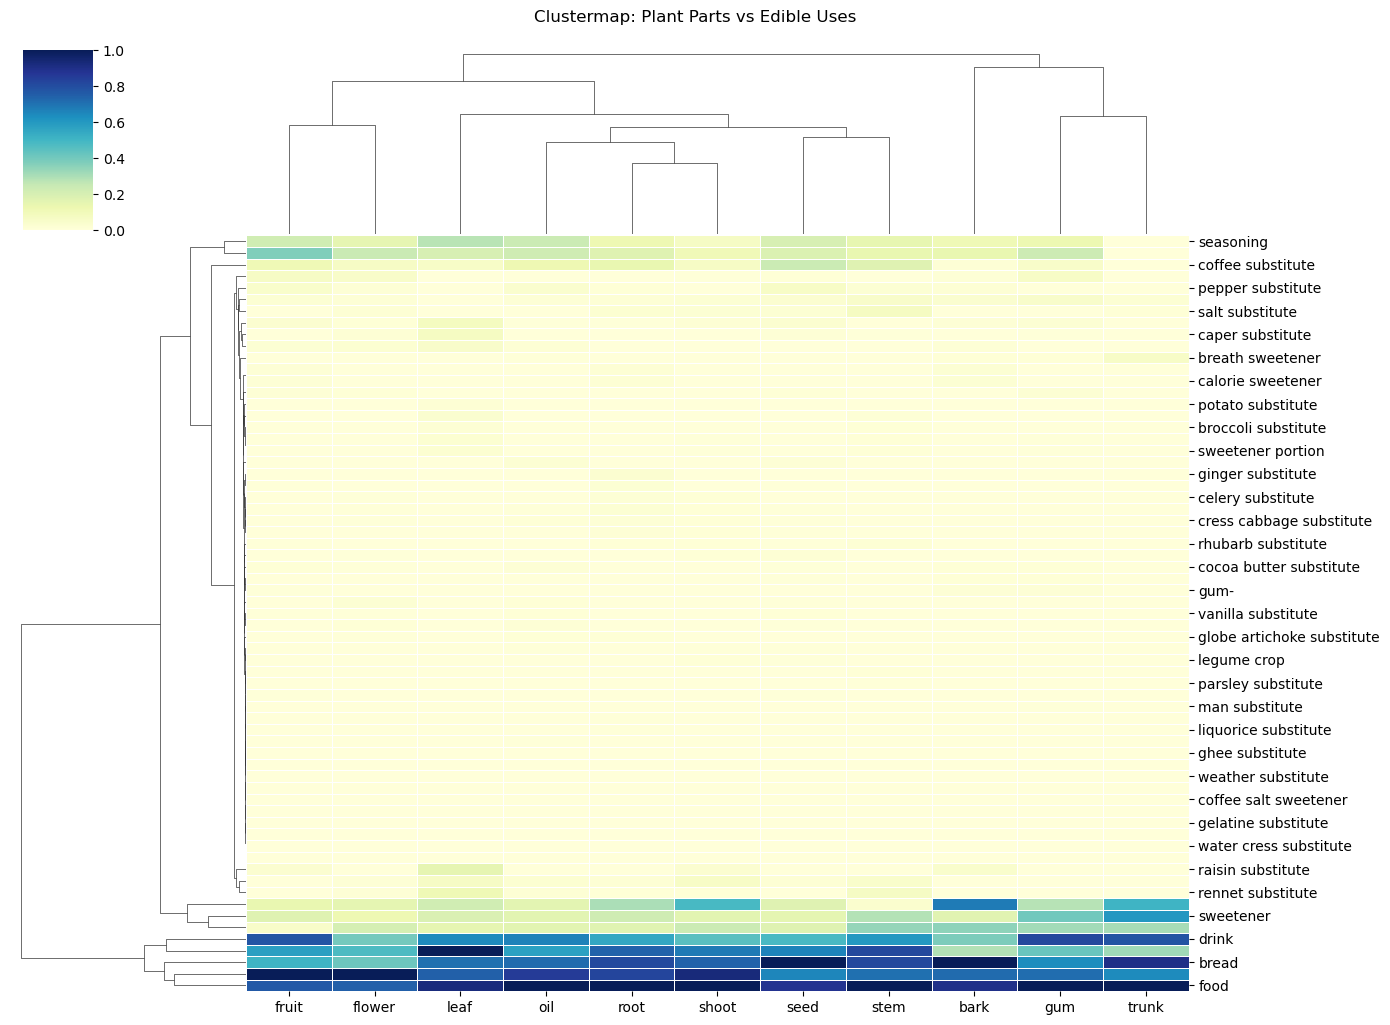

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# Create co-occurrence matrix
def make_co_matrix(row_col_lists):
    co_matrix = defaultdict(lambda: defaultdict(int))
    for _, row in df.iterrows():
        rows = row.get(row_col_lists[0], [])
        cols = row.get(row_col_lists[1], [])
        for r in rows:
            for c in cols:
                co_matrix[r][c] += 1
    return pd.DataFrame(co_matrix).fillna(0).astype(int).T

# Medicinal property × edible use
co_df_uses = make_co_matrix(["edible_uses_normalized", "edible_parts_normalized"])

# Plot clustermap
sns.clustermap(
    co_df_uses,
    cmap="YlGnBu",
    figsize=(14, 10),
    linewidths=0.5,
    metric="euclidean",  # or try "cosine" or "correlation"
    standard_scale=1,    # normalize each row
)
plt.suptitle("Clustermap: Plant Parts vs Edible Uses", y=1.02)
plt.show()

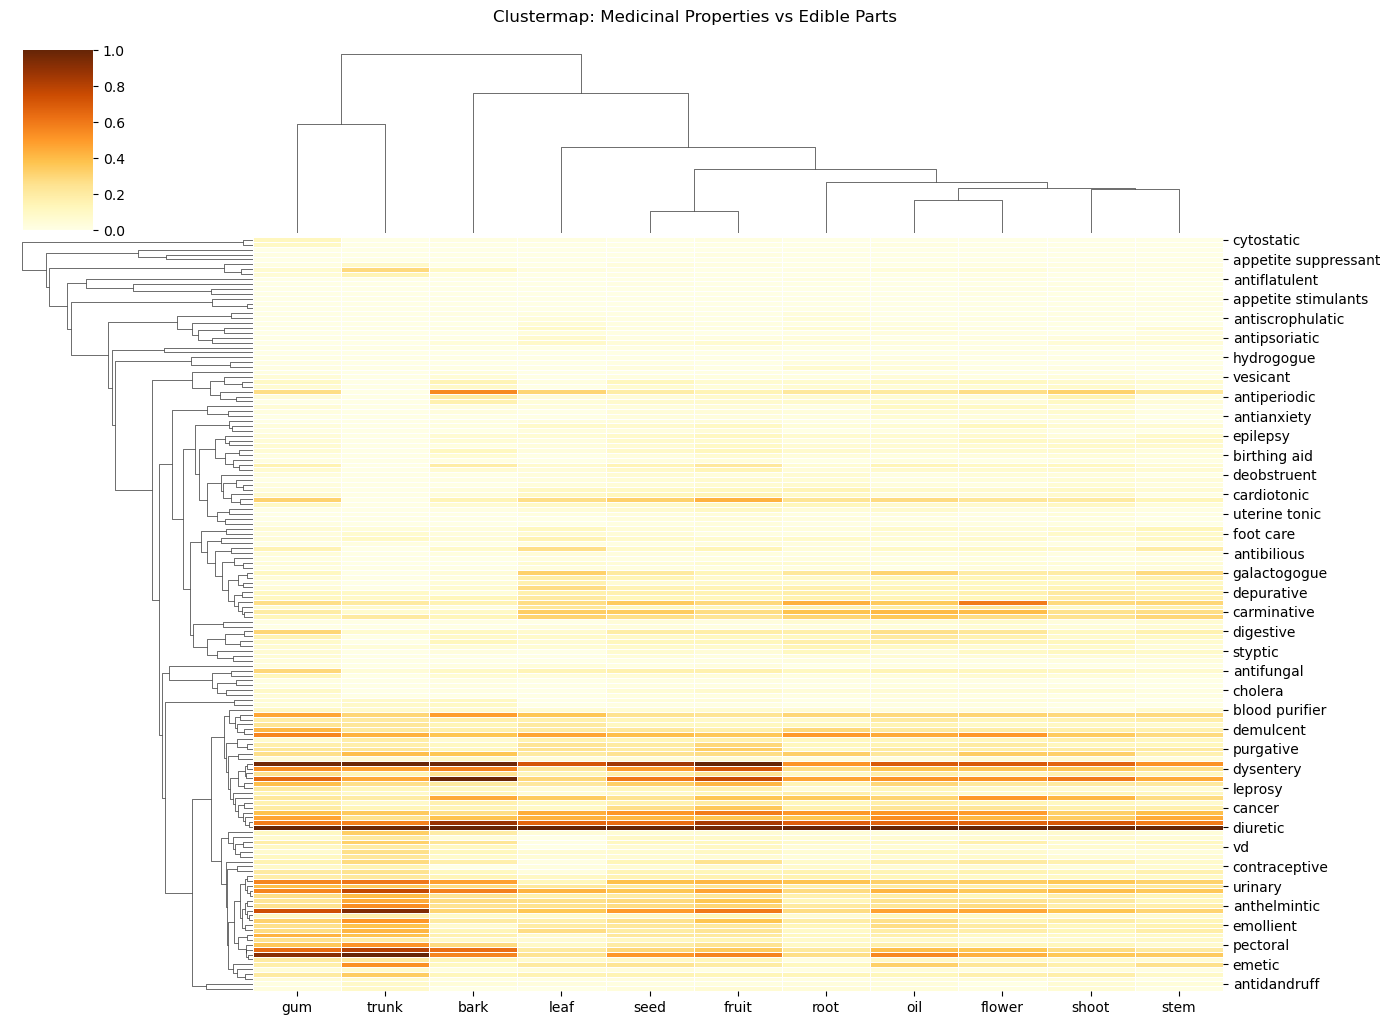

In [17]:
co_df_parts = make_co_matrix(["Medicinal properties_phrases", "edible_parts_normalized"])

sns.clustermap(
    co_df_parts,
    cmap="YlOrBr",
    figsize=(14, 10),
    linewidths=0.5,
    metric="cosine",  # try different metrics for insights
    standard_scale=1,
)
plt.suptitle("Clustermap: Medicinal Properties vs Edible Parts", y=1.02)
plt.show()

### Medicinal properties vs Native area

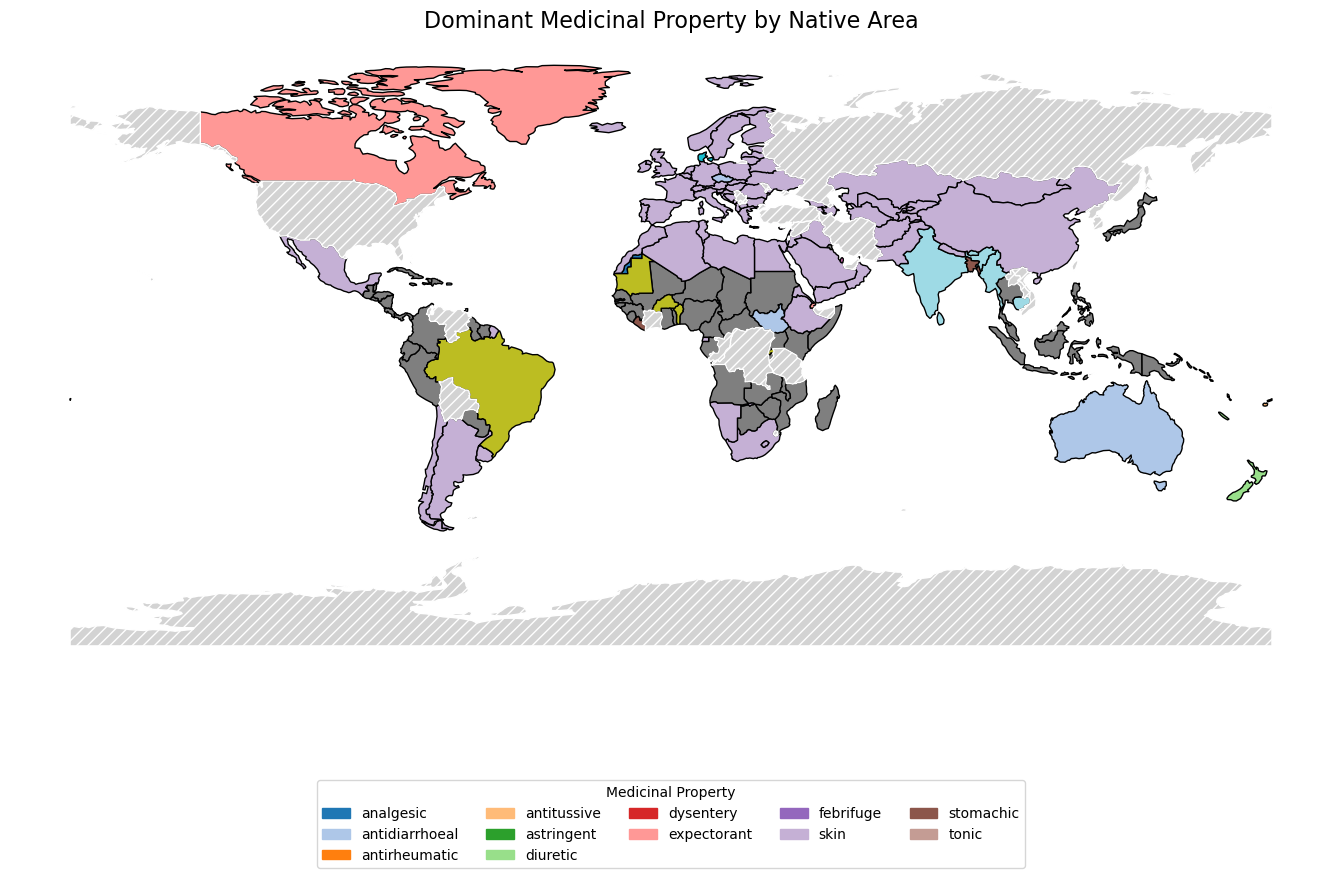

In [18]:
import pycountry
import re
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.io.shapereader as shpreader
import matplotlib.patches as mpatches

# 1. Setup known countries
known_countries = {c.name for c in pycountry.countries}
known_subdivisions = {s.name for s in pycountry.subdivisions}

def extract_geographical_scope_fast(text):
    if not isinstance(text, str):
        return []
    found = set()
    chunks = [re.sub(r"\(.*?\)", "", c).strip() for c in text.split(",")]
    for chunk in chunks:
        if chunk in known_countries or chunk in known_subdivisions:
            found.add(chunk)
        else:
            for country in known_countries:
                if chunk.lower() in country.lower():
                    found.add(country)
                    break
    return sorted(found)

# 2. Extract native countries
df["native_countries"] = df["Native area"].apply(extract_geographical_scope_fast)

# 3. Explode to long format
long_df = df[["native_countries", "Medicinal properties_phrases"]].explode("native_countries")
long_df = long_df.explode("Medicinal properties_phrases")
long_df = long_df.dropna(subset=["native_countries", "Medicinal properties_phrases"])

# 4. Most common medicinal property per country
country_property_mode = (
    long_df.groupby("native_countries")["Medicinal properties_phrases"]
    .agg(lambda x: pd.Series.mode(x)[0])  # pick one if multiple modes
    .reset_index()
    .rename(columns={"native_countries": "country", "Medicinal properties_phrases": "medicinal_property"})
)

# 5. Load world map
shpfilename = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
world = gpd.read_file(shpfilename)

# 6. Merge with world map
world_map = world.merge(country_property_mode, left_on="ADMIN", right_on="country", how="left")

# 7. Plot
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
world_map.plot(column="medicinal_property",
               ax=ax,
               cmap="tab20",
               legend=False,
               edgecolor="black",
               missing_kwds={
                   "color": "lightgray",
                   "edgecolor": "white",
                   "hatch": "///",
                   "label": "No data"
               })

# Build legend
all_props = world_map["medicinal_property"].dropna().unique()
color_mapping = {prop: plt.get_cmap("tab20")(i % 20) for i, prop in enumerate(sorted(all_props))}
patches = [mpatches.Patch(color=color_mapping[prop], label=prop) for prop in sorted(all_props)]

ax.set_title("Dominant Medicinal Property by Native Area", fontsize=16)
ax.axis("off")

# Add legend
fig.legend(handles=patches,
           loc="lower center",
           bbox_to_anchor=(0.5, -0.1),
           ncol=5,
           fontsize=10,
           title="Medicinal Property")

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

### Medicinal properties vs Family

In [21]:
# Explode medicinal properties
df_exp = df.copy()
df_exp = df_exp.explode("Medicinal properties_phrases")
df_exp = df_exp.rename(columns={"Medicinal properties_phrases": "Medicinal Property"})

# Clean the family names
df_exp["Family"] = df_exp["Family"].str.replace(r" or .*", "", regex=True)

# Get top 20 most common families
top_20_props = df_exp["Family"].value_counts().nlargest(20).index

# Filter to those top 20 families
df_filtered = df_exp[df_exp["Family"].isin(top_20_props)].copy()

# Add dummy count column for Plotly sizing
df_filtered["Count"] = 1

# Build the sunburst plot
sunburst_fig = px.sunburst(
    df_filtered,
    path=["Medicinal Property", "Family"],
    values="Count",
    title="Medicinal Properties vs top 20 Plant Families",
    width=1000,
    height=800
)

sunburst_fig.show()

In [22]:
import pandas as pd
import plotly.express as px

# Prepare full data without filtering top 20
df_exp = df.copy()
df_exp = df_exp.explode("Medicinal properties_phrases")
df_exp = df_exp.rename(columns={"Medicinal properties_phrases": "Medicinal Property"})

# Clean up family names
df_exp["Family"] = df_exp["Family"].str.replace(r" or .*", "", regex=True)

# Drop NaNs just in case
df_exp = df_exp.dropna(subset=["Medicinal Property", "Family"])

# Add dummy count column
df_exp["Count"] = 1

# Build the full sunburst chart
sunburst_all = px.sunburst(
    df_exp,
    path=["Medicinal Property", "Family"],
    values="Count",
    title="Medicinal Properties vs Plant Families",
    width=1000,
    height=900
)

sunburst_all.show()